In [15]:
using PyPlot
using Optim

In [16]:
# Convert an Float32 rbg image to Float64 grayscale image
function convert_to_grayscale(I::Array{Float32,3})
    I=convert(Array{Float64,3}, I)
    I_gray = 0.2989*I[:,:,1] + 0.5870*I[:,:,2] + 0.1140*I[:,:,3]
    return I_gray::Array{Float64,2}
end

convert_to_grayscale (generic function with 1 method)

In [17]:
# Load Tsukuba disparity dataset and convert it to grayscale
function load_data()
    i0_path = string(@__DIR__,"/i0.png")
    i0 = imread(i0_path)
    i0 = convert_to_grayscale(i0)
    i1_path = string(@__DIR__,"/i1.png")
    i1 = imread(i1_path)
    i1 = convert_to_grayscale(i1)
    gt_path = string(@__DIR__,"/gt.png")
    gt64 = convert(Array{Float64,2}, imread(gt_path)*255)

    @assert maximum(gt64) <= 16
    return i0::Array{Float64,2}, i1::Array{Float64,2}, gt64::Array{Float64,2}
end

load_data (generic function with 1 method)

In [19]:
function log_studentt(x::Float64, alpha::Float64, sigma::Float64)
    
    #TODO: Change the code to accept matrix input
    
    function log_student(x, alpha, sigma)
        return log((1 + (1/(2*sigma^2))*x^2)^(-1*alpha))
    end
    
    function log_grad_student(x, alpha, sigma)
        return -(2*alpha*x)/((2*sigma^2)+2x^2)
    end
    
    value = log_student(x, alpha, sigma)
    grad = log_grad_student(x, alpha, sigma)

    return value::Float64, grad::Float64
end

log_studentt (generic function with 1 method)

In [20]:
# Evaluate stereo log prior.
# Set: alpha=1.0, sigma=1.0
function stereo_log_prior(x::Array{Float64,2})
    alpha = 1.0
    sigma = 1.0
    value = 0
    grad = zeros(size(x))
    # Vertical potential
    for i = 1:size(x)[1]-1#Height?
        for j = 1:size(x)[2]#Width?
            value += log_studentt(x[i+1, j] - x[i,j], alpha, sigma)[1]
        end
    end 
    # Horizontal potential
    for i = 1:size(x)[1]#Height?
        for j = 1:size(x)[2]-1#Width?
            value += log_studentt(x[i, j+1] - x[i,j], alpha, sigma)[1]
        end
    end
    # Partial derivative to every pixel
    for k = 1:size(x)[1]
        for l = 1:size(x)[2]
            if k + 1 <= size(x)[1]
                grad[k,l] += log_studentt(x[k,l]-x[k+1,l], alpha, sigma)[2] 
            end
            if k - 1 >= 1
                grad[k,l] += log_studentt(x[k,l]-x[k-1,l], alpha, sigma)[2]
            end
            if l + 1 <= size(x)[2]
                grad[k,l] += log_studentt(x[k,l]-x[k,l+1], alpha, sigma)[2]
            end
            if l - 1 >= 1
                grad[k,l] += log_studentt(x[k,l]-x[k,l-1], alpha, sigma)[2]
            end
        end
    end
    return  value::Float64, grad::Array{Float64,2}
end


stereo_log_prior (generic function with 1 method)

In [21]:
# Calculates the gradient of a given image in both directions
function image_gradient(im::Array{Float64,2})
    horizontal_im_grad = zeros(size(im))
    vertical_im_grad = zeros(size(im))
    for x = 1:size(im)[1]
        for y = 1:size(im)[2]
            if x-1 > 0
                vertical_im_grad[x,y] -= im[x-1,y]
            end
            if x+1 < size(im)[1]
                vertical_im_grad[x,y] += im[x+1,y]
            end
            if y-1 > 0
                horizontal_im_grad[x,y] -= im[x,y-1]
            end
            if y+1 < size(im)[2]
                horizontal_im_grad[x,y] += im[x,y+1]
            end
        end
    end
    return horizontal_im_grad::Array{Float64,2}, vertical_im_grad::Array{Float64,2}
end

image_gradient (generic function with 1 method)

In [22]:
# Shift all pixels of i1 to the right by the value of gt
function shift_disparity(i1::Array{Float64,2}, gt::Array{Float64,2})
    # TODO: do interpolation... constant disparity map
    @assert size(i1) == size(gt)
    id = zeros(size(i1))
    for x = 1:size(i1)[2] 
        for y = 1:size(i1)[1]
            shifted_index = Int64(floor(x + gt[y,x]))
            if (shifted_index > 1) && (shifted_index < size(i1,2))
                id[y, shifted_index] = i1[y,x]          
            end
        end
    end
    @assert size(id) == size(i1)
    return id::Array{Float64,2}
end

shift_disparity (generic function with 1 method)

In [23]:
# Evaluate stereo log likelihood.
# Set: Alpha = 1.0, Sigma = 0.004
function stereo_log_likelihood(x::Array{Float64,2}, im0::Array{Float64,2}, im1::Array{Float64,2})
    alpha = 1.0
    sigma = 0.004
    value = 0
    grad = zeros(size(im1))
    # We can shift I1 by the disparity first
    im1_d = shift_disparity(im1, x)
    # We need the horizontal image derivative from I1 to calculate the gradient of the LH
    h_img_grad = image_gradient(im1_d)[1]
    for i = 1:size(x)[1]
        for j = 1:size(x)[2]
            d = im0[i,j]-im1_d[i, j]
            value += log_studentt(d, alpha, sigma)[1]
            grad[i,j] = (-1)*log_studentt(d, alpha, sigma)[2]*h_img_grad[i, j]          
        end
    end
    return value::Float64, grad::Array{Float64,2}
end

stereo_log_likelihood (generic function with 1 method)

In [24]:
# Evaluate stereo posterior
function stereo_log_posterior(x::Array{Float64,2}, im0::Array{Float64,2}, im1::Array{Float64,2}) 
    #log(posterior) = log(prior*LH) = log(prior) + log(LH)
    # (We can drop the marginalisation terms)
    log_posterior = stereo_log_likelihood(x, im0, im1)[1] + stereo_log_prior(x)[1] + stereo_log_prior(im0)[1]
    grad_lh = stereo_log_likelihood(x, im0, im1)[2]
    grad_x = stereo_log_prior(x)[2]
    # (Derivative of I0 to x should be zero, so we drop it ...)
    log_posterior_grad = grad_lh + grad_x
    return log_posterior::Float64, log_posterior_grad::Array{Float64,2}
end

stereo_log_posterior (generic function with 1 method)

In [25]:
# Run stereo algorithm using gradient ascent or sth similar
function stereo(x0::Array{Float64,2}, im0::Array{Float64,2}, im1::Array{Float64,2})
    print("\nRunning Stereo Algorithm...")
    # Helper function with fixed im0 and im1
    function f(y)
        value = -stereo_log_posterior(y, im0, im1)[1]
        return value
    end
    function g!(storage, y)
        grad = -stereo_log_posterior(y, im0, im1)[2]
        storage[:,:] = grad
    end
    options = Optim.Options(iterations=200, show_trace=false, allow_f_increases=true)
    # Specify optim algorithm here
    res = optimize(f, g!, x0, GradientDescent(), options)
    x = Optim.minimizer(res)
    print("done!")
    return x::Array{Float64,2}
end

stereo (generic function with 1 method)

In [26]:
# create constant disparity of all 8's of size DISPARITY_SIZE
function constant_disparity(disparity_size::Tuple{Int64,Int64})
    disparity_map = fill(8.0, disparity_size)
    return disparity_map::Array{Float64,2}
end

constant_disparity (generic function with 1 method)

In [27]:
# Create random disparity in [0,14] of size DISPARITY_SIZE
# We changed DISPARITY_SIZE to a tuple of integers
function random_disparity(disparity_size::Tuple{Int64,Int64})
    disparity_map = Array{Float64,2}(rand(collect(1:14),disparity_size))
    return disparity_map::Array{Float64,2}
end

random_disparity (generic function with 1 method)

In [28]:
function problem3()
    # use problem 2's load_data
    im0, im1, gt = load_data()

    # Display stereo: Initialized with constant 8's
    const_d = constant_disparity(size(gt))
    
    # Display stereo: Initialized with noise in [0,14]
    random_d = constant_disparity(size(gt))
    
    # print("\nLH const disp: ", stereo_log_likelihood(const_d, im0, im1)[1])
    x = stereo(random_d, im0, im1)
    figure()
    title("Estimated disparity map")
    imshow(x, "gray")
    show()
    figure()
    title("Ground truth disparity map")
    imshow(gt, "gray")
    show()
    
    

    # print("\nLH random disp: ", stereo_log_likelihood(random_d, im0, im1)[1])
    
    # Display stereo: Initialized with gt
    # print("\nLH GT disp: ", stereo_log_likelihood(gt, im0, im1)[1])
    
    # Coarse to fine estimation..

end


problem3 (generic function with 1 method)

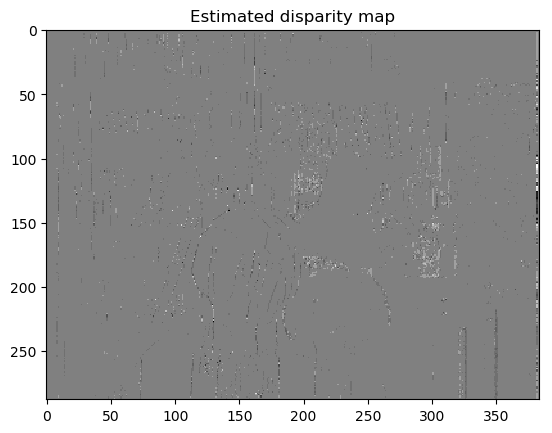

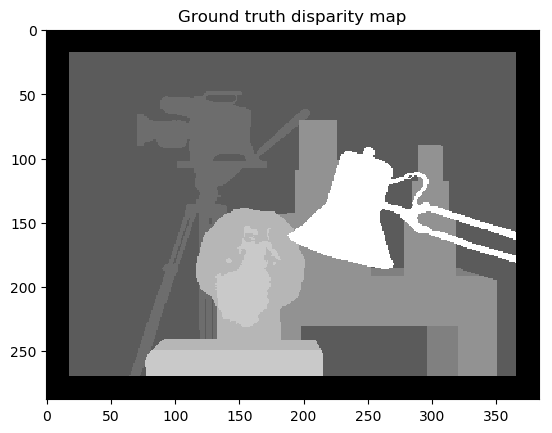


Running Stereo Algorithm...done!

In [29]:
problem3()

In [30]:
2^2+5

9

4